<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/Boris-staging/Notebooks/How_to_make_Volcano_plot_using_CPTAC_protein_expression_ovarian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ISB-CGC Community Notebooks

Check out more notebooks at our [Community Notebooks Repository](https://github.com/isb-cgc/Community-Notebooks)!

```
Title:   Volcano plot using CPTAC protein expression of Ovarian cancer
Author:  Boris Aguilar
Created: 2022-01-30
URL:     https://github.com/isb-cgc/Community-Notebooks/blob/master/Notebooks/Volcano_plot_using_CPTAC_protein_expression_of_ovarian_cancer.ipynb
Purpose: Demostrate how to generate a volcano plot using BigQuery tables of protein expression data.
Notes: 
```
This notebook uses CPTAC BigQuery tables of Ovarian cancer, and generates a Volcano plot similar to that of Figure 3A of [McDermott et al. Cell Rep Med. 2020; 1(1): 100004](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7289043/), a CPTAC paper that analyze proteomics data of Ovarian cancer patients.


## Packages
Load all R package dependencies, installing if necessary.

In [15]:
# BigQuery library
if (!require(bigrquery)) {
  install.packages('bigrquery')
  require(bigrquery)
}
# Tidyr package
if (!require('stringr')) {
  install.packages('stringr')
  require('stringr')
}
# Tidyr package
if (!require('stringr')) {
  install.packages('stringr')
  require('stringr')
}
# Scales package to support visualization
if (!require('ggplot2')) {
  install.packages('ggplot2')
  require('ggplot2')
}

# edgeR to support analysis
if (!require("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
    require("BiocManager")
}
BiocManager::install("edgeR")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.2 (2021-11-01)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'edgeR'”
Old packages: 'pbdZMQ', 'brew', 'generics', 'pillar', 'readr', 'rlang',
  'svglite', 'tidyr'



## Authenticate to Access BigQuery
Before using BigQuery, we need to get authorization for access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html). R notebooks that use the BigRQuery library need the following work-around to authenticate. See the following link: https://gist.github.com/jobdiogenes/235620928c84e604c6e56211ccf681f0

In [14]:
# NOTE: this cell is only required if you're using Google Colab
if (!require('R.utils')) {
    install.packages("R.utils")
}
if (!require('httr')) {
    install.pckages('httr')
}

my_check <- function() {return(TRUE)}
reassignInPackage("is_interactive", pkgName = "httr", my_check) 
options(rlang_interactive=TRUE)

In [4]:
# Now authenticate to BQ. Be sure to select the BigQuery scope!
bq_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/auth?client_id=603366585132-dpeg5tt0et3go5of2374d83ifevk5086.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/1AX4XfWiuAhMIdzaDhzrYrdCMmI4RupiMazS7qfW4ezmzIzCCurIQ7JlZ_bA


## Libraries

In [5]:
library(bigrquery)
library(stringr)
library(ggplot2)
library(edgeR)
library(tidyr)
project <- '' # Write your google project id here.

Loading required package: limma


Attaching package: ‘tidyr’


The following object is masked from ‘package:R.utils’:

    extract




## Retrieve Data

These commands create a query that joins two tables, one that contains protein expression from Ovarian cancer patients (isb-cgc-bq.CPTAC.quant_proteome_prospective_ovarian_PNNL_qeplus_pdc_current) and another table that contains  information of patient samples ( isb-cgc-bq.PDC_metadata.aliquot_to_case_mapping_current). This query retrieve sample type (cancerous or normal), gene names (gene_symbol), and protein expression or abundance. 

In [6]:
sql1 <- "
SELECT IF( sample_type = 'Primary Tumor', 
           CONCAT('C', meta.case_submitter_id), 
           CONCAT('N', meta.case_submitter_id)) AS case_submitter_id, 
       quan.gene_symbol, 
       protein_abundance_log2ratio as abundance
FROM `isb-cgc-bq.CPTAC.quant_proteome_prospective_ovarian_PNNL_qeplus_pdc_current` as quan
JOIN `isb-cgc-bq.PDC_metadata.aliquot_to_case_mapping_current` as meta
        ON quan.case_id = meta.case_id
        AND quan.aliquot_id = meta.aliquot_id
        AND meta.project_name = 'CPTAC2 Confirmatory'
ORDER BY case_submitter_id
"

The following commands retrieve the desired information from the cloud

In [7]:
unpivot_tbl <- bq_project_query (project, query = sql1) #Put data in temporary BQ table
unpivot_data <- bq_table_download(unpivot_tbl) #Put data into a dataframe
head(unpivot_data)

case_submitter_id gene_symbol  abundance
1 C01OV007          LOC105369247 -0.3350  
2 C01OV007          LOC101060405     NaN  
3 C01OV007          CYTB          0.0043  
4 C01OV007          COX1          0.0838  
5 C01OV007          COX2         -0.4224  
6 C01OV007          COX3          0.0888

BigQuery tables typically have tidy format. For this analysis, we need to pivot the table such that each column corresponds to sample ids (case_submitter_id). Then we delete rows (genes) with NA values.

In [8]:
df = spread(unpivot_data, case_submitter_id,  abundance)
row_table <- df  %>%  drop_na

Following the same procedure specified by [McDermott et al. Cell Rep Med. 2020; 1(1): 100004](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7289043/), we delete the data from sample N17OV001 and average the protein abundance for each gene

In [9]:
mydf = subset( df, select = -c( N17OV001) )
agg_df = aggregate(.~gene_symbol, mydf, mean)

Then we set the gene names (gene_symbol column) as index of the dataframe.

In [10]:
agg_pdf <- agg_df[,-1]
rownames(agg_pdf) <- agg_df[,1]
head(agg_pdf)

C01OV007 C01OV017 C01OV018 C01OV023 C01OV026 C01OV029 C01OV030 C01OV039
A1BG  -0.0310  -0.3964  -0.6135   0.8268  -0.5403  -0.9771  -0.1226  -1.1519 
A2M    0.4694  -0.4366  -0.1953   0.9754   0.1521  -0.4794  -0.3090  -0.6133 
A2ML1 -0.5561  -0.6267  -0.1352  -0.3891  -3.0901  -0.8589  -1.7998  -0.9436 
AAAS   0.2473   0.1387  -0.0843   0.2441   0.4030   0.0325   0.0675   0.8106 
AACS   0.0028   0.5439   0.6288   0.0261   0.1816  -0.5467  -0.0955   0.9098 
AAGAB  0.0807   0.4445   0.1813   0.4318   0.0144  -0.0186   0.0646  -0.5741 
      C01OV041 C01OV047 ⋯ N01OV039 N11OV002 N11OV010 N14OV011 N14OV029 N15OV001
A1BG  -0.4095   0.0970  ⋯  0.9657   1.6826   1.6522   0.1598   2.0637   1.4634 
A2M   -0.4618  -0.1532  ⋯  0.5141   1.1342   0.9555   0.9163   2.9083   1.8210 
A2ML1 -1.7904   0.4066  ⋯  3.9666  -0.8844  -1.2389  -0.4644   0.0300   0.9456 
AAAS   0.3457   0.2091  ⋯ -0.4465  -0.0680  -0.2249  -0.1383  -0.3704  -0.3378 
AACS  -0.3147   0.4041  ⋯ -0.1535  -0.4677  -0.1221   0.8530   0.1151  -0.2599 
AAGAB -0.0465   0.1827  ⋯ -0.3292  -0.3167  -0.1110  -0.4485  -0.4659  -0.0342 
      N17OV002 N17OV003 N17OV004 N17OV005
A1BG   1.5573   1.0918   0.7167   1.5052 
A2M    1.3842   2.9949   1.7822   1.4131 
A2ML1  0.7569   0.0314   2.7622   0.0927 
AAAS  -0.0801   0.1995  -0.3542  -0.0646 
AACS   0.6305  -0.2490   1.2992   0.5415 
AAGAB -0.4440   0.0227  -0.3950  -0.6133

## Differential Expression Analysis

Finally, we are ready to use edgeR to compute protein expression differences and statistical measures. 

Specifically we fit the data to the linear models, one model for each gene in gene expression set. Note that the fitting process is split into two function calls, lmFit and eBayes, which are both necessary.

In [11]:
cnames = colnames(agg_pdf) #
fac = factor(rep( c("tumor","normal"), c(84,18) )) # there are 84 cancerous and 18 normal samples. 

fit <- lmFit(agg_pdf, design=model.matrix(~ fac))
fit <- eBayes(fit)


## Displaying results
The function topTable lists the genes, with the most significantly differentiated (cancerous vs normal) genes at the top. For a more detailed description of the columns please visit: https://wiki.bits.vib.be/index.php/Tutorial:_Testing_for_differential_expression_I 

For visualization we sabed the tables of genes with fold changes greater of equal than 0.5 (tt_high1) and 1.0 (tt_high2). 

In [12]:
tt <- topTable(fit, n=Inf, coef=2)
tt_high1 <- topTable(fit, n=Inf, coef=2, lfc = 0.5)
tt_high2 <- topTable(fit, n=Inf, coef=2, lfc = 1.0)

head(tt)

logFC     AveExpr     t         P.Value      adj.P.Val    B       
OGN   -3.747109 -0.88427647 -16.57358 5.494037e-31 3.767811e-27 59.90879
ITGA7 -2.304933 -0.10680196 -15.65745 3.835328e-29 1.315134e-25 55.73648
LAMB2 -1.964599  0.06163922 -15.44381 1.047863e-28 2.125728e-25 54.74794
SYNM  -3.121135 -0.68622941 -15.40816 1.239853e-28 2.125728e-25 54.58244
CDH13 -2.476388 -0.13725588 -15.26327 2.460712e-28 3.186168e-25 53.90805
SOD3  -2.781924 -0.31016275 -15.23697 2.787549e-28 3.186168e-25 53.78534

## Visualize Results

Finally, the following steps generate the volcano plot. The following link provides a detailed explanation of the steps to generate Volcano plots: https://wiki.bits.vib.be/index.php/Tutorial:_Testing_for_differential_expression_I


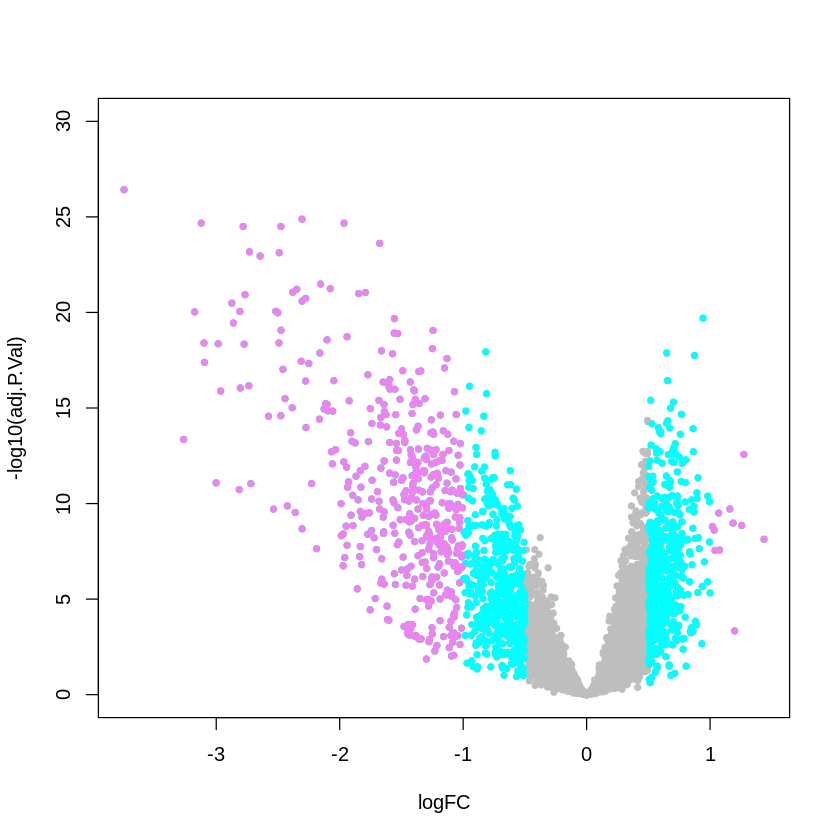

In [13]:
plot(-log10(adj.P.Val) ~ logFC, data=tt, pch=20  , ylim=c(0,30 ), col = 'grey') 
points(-log10(adj.P.Val) ~ logFC, data=tt_high1, pch=20, col="cyan")
points(-log10(adj.P.Val) ~ logFC, data=tt_high2, pch=20, col="violet")

The figure above is a Volcano plot representation of differential protein expression in tumor versus normal samples of Ovarian cancer patiens. This plot is very similar to Figure 3A of [McDermott et al. Cell Rep Med. 2020; 1(1): 100004](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7289043/).

The x axis of the plot represents the log2-fold change of protein expression of cancer samples relative to normal ones, and the y axis is the adjusted p-value (after a log10 transformation) of the t-statistic for the hypothesis that the log2-fold change is zero (or equivalently, that the fold change is one). Cyan and violet dots represent proteins with log2-fold changes greater or equal than 1.0 and 0.5, respectively. 